### Using RGB, Stereo and Crate Dimensions In This Notebook For Keypoint Detection

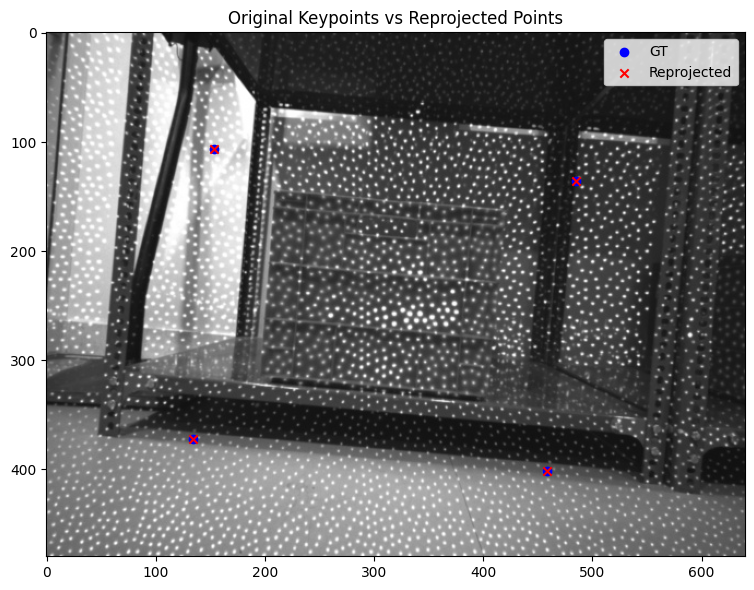

Pixel Reprojection Errors: [3.17764372e-14 2.84217094e-14 0.00000000e+00 0.00000000e+00]
Mean error: 1.5049536647992276e-14


,X,Y,Z
KPt 0,-593.732569,-475.475321,1383.0
KPt 1,555.034687,-344.220414,1293.0
KPt 2,259.154648,302.160325,721.0
KPt 3,-344.478730,247.744498,720.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from PIL import Image
import os
import pandas as pd

base_path = './neuralzome_crate_local/2024-01-31-09-51-48'
img_file = '1.jpg'
yaml_file = '1.yaml'
left_img_path = os.path.join(base_path, 'stereo/left', img_file)
depth_path = os.path.join(base_path, 'stereo/depth', img_file.replace('.jpg', '.npy'))
yaml_path = os.path.join(base_path, 'rgb', yaml_file)


left_img = np.array(Image.open(left_img_path).convert('RGB'))
depth_map = np.load(depth_path)

with open(yaml_path, 'r') as f:
    crate = yaml.safe_load(f)['crates'][0]

keypoints_2d = np.array([
    [crate['x0'], crate['y0']],
    [crate['x1'], crate['y1']],
    [crate['x2'], crate['y2']],
    [crate['x3'], crate['y3']]
], dtype=np.float32)

# ---------------------- Camera Intrinsics ----------------------
K = np.array([
    [386.690, 0, 319.009],
    [0, 386.690, 238.944],
    [0, 0, 1]
])

# ---------------------- 2D → 3D Backprojection ----------------------
keypoints_3d = []
for (u, v) in keypoints_2d:
    u_int, v_int = int(round(u)), int(round(v))
    if 0 <= u_int < depth_map.shape[1] and 0 <= v_int < depth_map.shape[0]:
        z = depth_map[v_int, u_int]
    else:
        z = 0

    if z > 0:
        x = (u - K[0, 2]) * z / K[0, 0]
        y = (v - K[1, 2]) * z / K[1, 1]
        keypoints_3d.append([x, y, z])
    else:
        keypoints_3d.append([np.nan, np.nan, np.nan])
keypoints_3d = np.array(keypoints_3d)

# ---------------------- 3D → 2D Reprojection ----------------------
proj_keypoints = []
for X in keypoints_3d:
    if np.isnan(X).any():
        proj_keypoints.append([np.nan, np.nan])
    else:
        X_h = X.reshape(3, 1)
        x_proj = K @ X_h
        x_proj /= x_proj[2]
        proj_keypoints.append(x_proj[:2].flatten())
proj_keypoints = np.array(proj_keypoints)

# ---------------------- Visualization ----------------------
plt.figure(figsize=(10, 6))
plt.imshow(left_img)
plt.title("Original Keypoints vs Reprojected Points")
for i, ((u, v), (u2, v2)) in enumerate(zip(keypoints_2d, proj_keypoints)):
    if not np.isnan(u2):
        plt.plot([u, u2], [v, v2], 'g--', linewidth=0.8)
        plt.scatter(u, v, color='blue', label='GT' if i == 0 else "", marker='o')
        plt.scatter(u2, v2, color='red', label='Reprojected' if i == 0 else "", marker='x')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------- Error Report ----------------------
errors = np.linalg.norm(keypoints_2d - proj_keypoints, axis=1)
print("Pixel Reprojection Errors:", errors)
print("Mean error:", np.nanmean(errors))

# Display 3D coordinates
pd.DataFrame(keypoints_3d, columns=["X", "Y", "Z"], index=[f"KPt {i}" for i in range(4)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


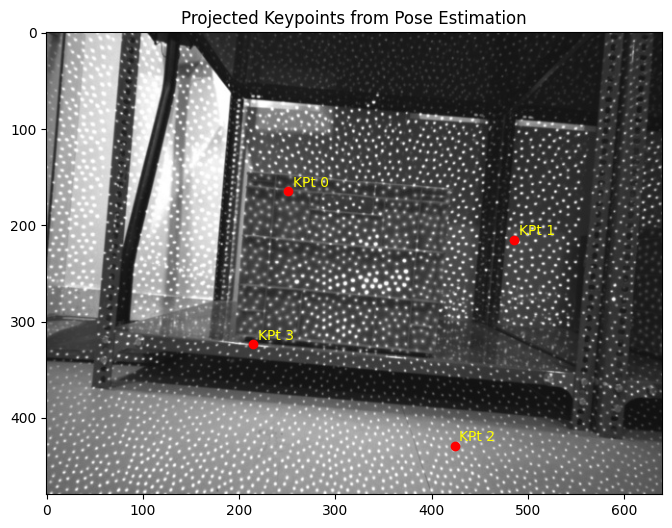

,x,y
KPt 0,250.975906,164.710526
KPt 1,485.443451,215.049789
KPt 2,423.818146,429.364777
KPt 3,214.898056,323.723694


In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd

def keypoint_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

model = load_model('../final.keras', custom_objects={'keypoint_loss': keypoint_loss})

base_path = './neuralzome_crate_local/2024-01-31-09-51-48'
img_file = '1.jpg'
yaml_file = '1.yaml'
left_img_path = os.path.join(base_path, 'stereo/left', img_file)
depth_path = os.path.join(base_path, 'stereo/depth', img_file.replace('.jpg', '.npy'))
yaml_path = os.path.join(base_path, 'rgb', yaml_file)

# --- Camera intrinsics (LEFT) ---
K = np.array([
    [386.690, 0, 319.009],
    [0, 386.690, 238.944],
    [0, 0, 1]
])

# --- Crate Dimensions (in meters) ---
W, H = 0.4, 0.3  # width, height

# --- Load full-size image ---
img = np.array(Image.open(left_img_path).convert('RGB')).astype(np.float32) / 255.0  # (480, 640, 3)
depth_map = np.load(depth_path)
orig_img = img.copy()

# --- Run model prediction ---
pred = model.predict(img[None])[0]

# --- Determine output type ---
if pred.shape[-1] == 8:
    # Regression output
    keypoints_2d = pred.reshape(4, 2)  # Already in pixel space
    confidences = np.ones(4)
else:
    # Heatmap output
    def extract_peak(heatmap):
        idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        return idx[::-1]  # (x, y)

    keypoints_2d = [extract_peak(pred[:, :, i]) for i in range(4)]
    confidences = [np.max(pred[:, :, i]) for i in range(4)]

# --- Select highest confidence keypoint ---
best_idx = int(np.argmax(confidences))
best_kpt_2d = np.array(keypoints_2d[best_idx])

# --- Get depth at that pixel ---
u, v = best_kpt_2d.astype(int)
z = depth_map[min(v, depth_map.shape[0]-1), min(u, depth_map.shape[1]-1)]

# --- Backproject to 3D ---
x = (u - K[0, 2]) * z / K[0, 0]
y = (v - K[1, 2]) * z / K[1, 1]
best_kpt_3d = np.array([x, y, z], dtype=np.float32)

# --- Estimate pose using 1 2D-3D point ---
object_points = np.array([
    [0, 0, 0],
    [W, 0, 0],
    [W, H, 0],
    [0, H, 0],
], dtype=np.float32)

image_points = np.array(keypoints_2d, dtype=np.float32)
object_points_used = object_points  # (4, 3)

success, rvec, tvec = cv2.solvePnP(object_points_used, image_points, K, None, flags=cv2.SOLVEPNP_ITERATIVE)
R, _ = cv2.Rodrigues(rvec)

# --- Project full 3D crate corners to 2D ---
projected_2d, _ = cv2.projectPoints(object_points, rvec, tvec, K, None)
projected_2d = projected_2d.squeeze()

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.imshow(orig_img)
for i, (x, y) in enumerate(projected_2d):
    plt.scatter(x, y, color='red')
    plt.text(x + 5, y - 5, f'KPt {i}', color='yellow')
plt.title("Projected Keypoints from Pose Estimation")
plt.show()

# --- Output Table ---
pd.DataFrame(projected_2d, columns=["x", "y"], index=[f"KPt {i}" for i in range(4)])
